In [89]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.optim
# CODE FILES HERE
from examples.vae.vae import Encoder, Decoder, Vae, PATH
from solver import Solver
from dataloader import DataLoader
from plot import plot_losses, plot_gauss_distributions, plot_rl_kl, plot_latent_space, plot_vis_latent_manifold, plot_gallery

%matplotlib inline
#plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [103]:
batch_size = 128
optimizer = torch.optim.Adam
num_normal_plots = 4

In [104]:
dataset = "MNIST"

if dataset == "MNIST" or dataset == "EMNIST":
    epochs = 12
    learning_rate = 1e-3
    h = 28
    w = 28
    #img_dims = (h, w)
    input_dim = np.prod((h, w))
    hidden_dim = 500 # Kingma, Welling use 500 neurons, otherwise use 400
    z_dim = 2 # 1000 is suggested in the paper "Tutorial on VAE" but Kingma, Welling show 20 is sufficient for MNIST
    weight_decay = 0
elif dataset == "LFW":
    epochs = 100
    learning_rate = 0.01 # 1e-2 works well
    h = 50
    w = 37
    img_dims = (h, w)
    input_dim = np.prod((h, w))
    hidden_dim = 600 # TODO: 1200? 200 in Kingma for Frey Face, but we could maybe use 250 or 300 because we have more samples?
    z_dim = 20
    weight_decay = 1e-4

In [105]:
encoder = Encoder(input_dim, hidden_dim, z_dim)
decoder = Decoder(z_dim, hidden_dim, input_dim)
model = Vae(encoder, decoder)

In [108]:
data_loader = DataLoader(PATH, batch_size, dataset, z_dim)
solver = Solver(model, data_loader, optimizer, z_dim, (h, w), epochs, num_normal_plots, weight_decay, batch_size, learning_rate)
solver.run()

+++++ START RUN +++++
====> Epoch: 1 train set loss avg: 163.0852
====> Test set loss avg: 180.3941
47.409953355789185 seconds for epoch 1
====> Epoch: 2 train set loss avg: 159.7415
====> Test set loss avg: 178.7941
52.284690856933594 seconds for epoch 2
====> Epoch: 3 train set loss avg: 157.5870
====> Test set loss avg: 176.6513
57.514893770217896 seconds for epoch 3
====> Epoch: 4 train set loss avg: 156.0232
====> Test set loss avg: 176.0009
55.060993671417236 seconds for epoch 4
====> Epoch: 5 train set loss avg: 154.8547
====> Test set loss avg: 175.1553
76.28008317947388 seconds for epoch 5
====> Epoch: 6 train set loss avg: 153.8733
====> Test set loss avg: 173.6066
56.691311836242676 seconds for epoch 6
====> Epoch: 7 train set loss avg: 153.1111
====> Test set loss avg: 176.3611
73.19249057769775 seconds for epoch 7
====> Epoch: 8 train set loss avg: 152.3917
====> Test set loss avg: 174.8016
74.14273452758789 seconds for epoch 8
====> Epoch: 9 train set loss avg: 151.9029
=

In [115]:
last_train_loss = list(list(zip(*solver.train_loss_history))[1])[-1]
torch.save(solver.model, "../models/VAE_" + dataset + "_train_loss=" + "{0:.2f}".format(last_train_loss) + "_z=" + str(z_dim) + ".model")

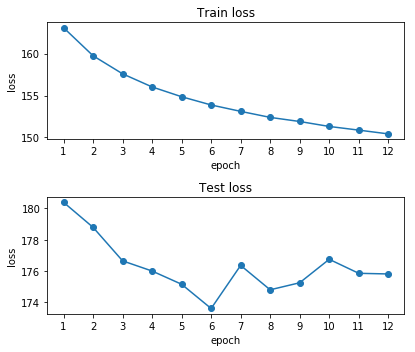

In [116]:
# Plotting train and test losses for all epochs
train_loss_history = list(list(zip(*solver.train_loss_history))[1])
plot_losses(solver, train_loss_history, solver.test_loss_history)

epoch: 5, mu(z): -0.13823575482193404, stddev(z): 1.313065191830145, var(z): 1.7241401979959357, var(mu(z)): 1.9504213333129883


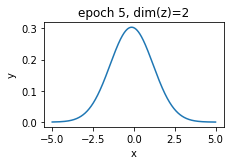

epoch: 10, mu(z): -0.10380034327908143, stddev(z): 1.265553393089441, var(z): 1.601625390760197, var(mu(z)): 1.6456587314605713


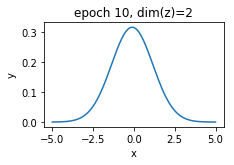

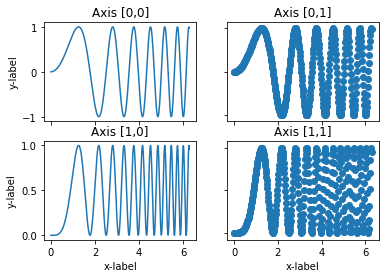

In [102]:
# Plotting histogram of the latent space's distribution, given the computed \mu and \sigma
if (num_normal_plots % 2) == 0: # (num_normal_plots % 4) == 0
    plot_gauss_distributions(solver, num_normal_plots)

epoch: 1, train_loss: 188.25405, test_loss: 183.63960, recon. loss: 182.68665, KL div.: 5.56753
overfitting: 4.61445
epoch: 2, train_loss: 166.33057, test_loss: 180.73575, recon. loss: 161.04280, KL div.: 5.28769
overfitting: 14.40518
epoch: 3, train_loss: 162.91384, test_loss: 180.15308, recon. loss: 157.54201, KL div.: 5.37187
overfitting: 17.23924
epoch: 4, train_loss: 160.76661, test_loss: 179.61036, recon. loss: 155.31644, KL div.: 5.45014
overfitting: 18.84375
epoch: 5, train_loss: 159.10067, test_loss: 178.01379, recon. loss: 153.57095, KL div.: 5.52983
overfitting: 18.91312
epoch: 6, train_loss: 157.88581, test_loss: 181.04477, recon. loss: 152.27806, KL div.: 5.60792
overfitting: 23.15896
epoch: 7, train_loss: 156.90947, test_loss: 179.10471, recon. loss: 151.25653, KL div.: 5.65293
overfitting: 22.19524
epoch: 8, train_loss: 156.04715, test_loss: 180.61359, recon. loss: 150.35904, KL div.: 5.68809
overfitting: 24.56644
epoch: 9, train_loss: 155.25848, test_loss: 179.43370, re

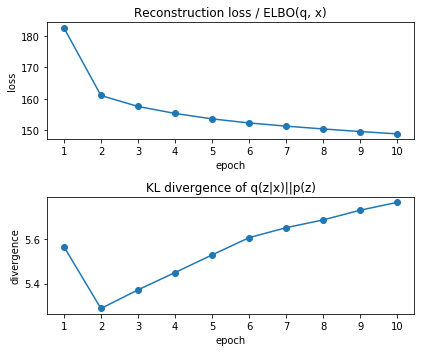

In [83]:
# Monitoring the reconstruction loss (likelihood lower bound) and KL divergence
rls = list(list(zip(*solver.train_loss_history))[2])
kls = list(list(zip(*solver.train_loss_history))[3])
for ((epoch, train_loss, rl, kl), test_loss) in zip(solver.train_loss_history, solver.test_loss_history):
    print("epoch: {}, train_loss: {:.5f}, test_loss: {:.5f}, recon. loss: {:.5f}, KL div.: {:.5f}".format(epoch, train_loss, test_loss, rl, kl))
    print("overfitting: {:.5f}".format(abs(test_loss-train_loss)))
plot_rl_kl(solver, rls, kls)

MemoryError: In RendererAgg: Out of memory

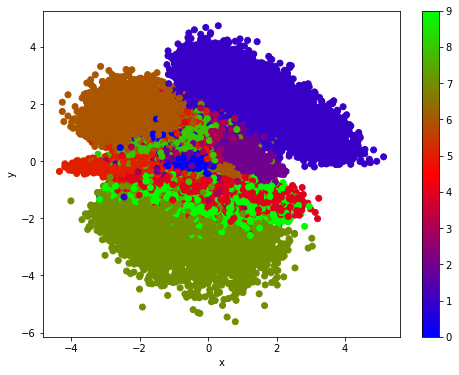

RuntimeError: libpng signaled error

<Figure size 0.00240385x72 with 1 Axes>

In [93]:
# visualize q(z|x) (latent space z)
if solver.z_dim == 2 and dataset == "MNIST":
    plot_latent_space(solver)
else:
    print("Plot of latent space not possible as dimension of z is not 2")

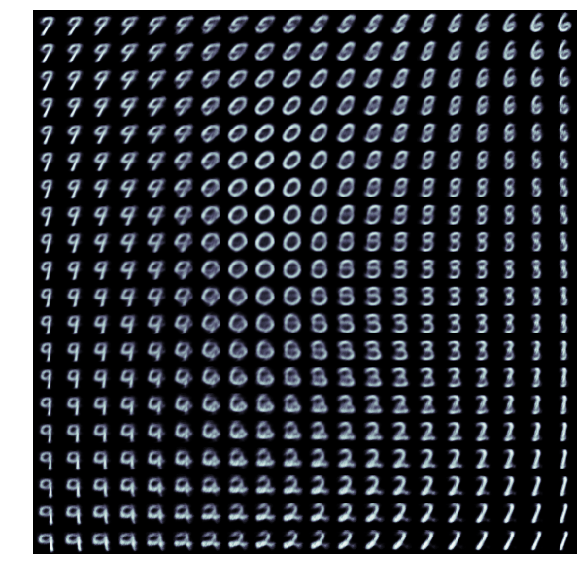

In [55]:
# Visualizations of learned data manifold for generative models with two-dimensional latent space
if solver.z_dim == 2:
    plot_vis_latent_manifold(solver)
else:
    print("Plot is not possible as dimension of z is not 2")

In [92]:
# TODO: Add gallery plots here
